In [7]:
import argparse
import copy
import random
import tqdm
import json

import gym
import torch

import memory
from memory import Transition
import networks
from utils import np_to_unsq_tensor, squeeze_np
from experiment_utils import Plot

In [8]:
from hyperparams.qrdqn_hyper import *

In [17]:
from sb3_contrib import QRDQN

In [24]:
from stable_baselines3 import DQN

In [25]:
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func



In [10]:
env_name = "LunarLander-v2"
env = gym.make(env_name, render_mode="human")

In [32]:
hyperparams = hyperparams_lunarlander
# if hyperparams['normalize']:
#     env = normalize_env(env)
lr = eval(hyperparams['learning_rate'].split('_')[1])
model = QRDQN(
            hyperparams['policy'], 
            env,
            batch_size=hyperparams['batch_size'],
            buffer_size=hyperparams['buffer_size'],
            exploration_final_eps=hyperparams['exploration_final_eps'],
            exploration_fraction=hyperparams['exploration_fraction'],
            gamma=hyperparams['gamma'],
            gradient_steps=hyperparams['gradient_steps'],
            learning_rate=linear_schedule(lr),
            learning_starts=hyperparams['learning_starts'],
            policy_kwargs=eval(hyperparams['policy_kwargs']),
            target_update_interval=hyperparams['target_update_interval'],
            train_freq=hyperparams['train_freq'],
            verbose=1
            )

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/alpayozkan/opt/anaconda3/envs/distrl_proj/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


0.0015

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -292.98
Saving new best model to tmp/best_model
Num timesteps: 2000
Best mean reward: -292.98 - Last mean reward per episode: -235.87
Saving new best model to tmp/best_model
Num timesteps: 3000
Best mean reward: -235.87 - Last mean reward per episode: -211.91
Saving new best model to tmp/best_model
Num timesteps: 4000
Best mean reward: -211.91 - Last mean reward per episode: -202.24
Saving new best model to tmp/best_model
Num timesteps: 5000
Best mean reward: -202.24 - Last mean reward per episode: -198.55
Saving new best model to tmp/best_model
Num timesteps: 6000
Best mean reward: -198.55 - Last mean reward per episode: -196.70
Saving new best model to tmp/best_model
Num timesteps: 7000
Best mean reward: -196.70 - Last mean reward per episode: -197.33
Num timesteps: 8000
Best mean reward: -196.70 - Last mean reward per episode: -196.44
Saving new best model to tmp/best_model
Num timesteps: 9000
Best mean rewar

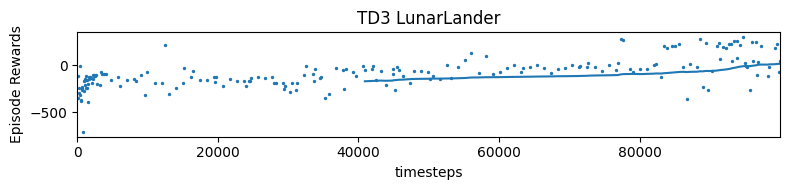

In [39]:
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback


class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True

# Create log dir
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('LunarLanderContinuous-v2')
env = Monitor(env, log_dir)

# Add some action noise for exploration
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
# Because we use parameter noise, we should use a MlpPolicy with layer normalization
model = TD3('MlpPolicy', env, action_noise=action_noise, verbose=0)
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Train the agent
timesteps = 1e5
model.learn(total_timesteps=int(timesteps), callback=callback)

plot_results([log_dir], timesteps, results_plotter.X_TIMESTEPS, "TD3 LunarLander")
plt.show()

In [77]:
plot_results([log_dir], timesteps, results_plotter.X_TIMESTEPS, "TD3 LunarLander")
plt.show()

ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.

In [106]:
from utils import *

__main__.SaveOnBestTrainingRewardCallback

In [68]:
results_plotter.plot_curves

<function stable_baselines3.common.results_plotter.plot_curves(xy_list: List[Tuple[numpy.ndarray, numpy.ndarray]], x_axis: str, title: str, figsize: Tuple[int, int] = (8, 2)) -> None>

In [73]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from stable_baselines3.common.results_plotter import load_results

# matplotlib.use('TkAgg')  # Can change to 'Agg' for non-interactive mode
plt.rcParams['svg.fonttype'] = 'none'

X_TIMESTEPS = 'timesteps'
X_EPISODES = 'episodes'
X_WALLTIME = 'walltime_hrs'
POSSIBLE_X_AXES = [X_TIMESTEPS, X_EPISODES, X_WALLTIME]
EPISODES_WINDOW = 100
COLORS = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'pink',
          'brown', 'orange', 'teal', 'coral', 'lightblue', 'lime', 'lavender', 'turquoise',
          'darkgreen', 'tan', 'salmon', 'gold', 'lightpurple', 'darkred', 'darkblue']


def rolling_window(array, window):
    """
    apply a rolling window to a np.ndarray

    :param array: (np.ndarray) the input Array
    :param window: (int) length of the rolling window
    :return: (np.ndarray) rolling window on the input array
    """
    shape = array.shape[:-1] + (array.shape[-1] - window + 1, window)
    strides = array.strides + (array.strides[-1],)
    return np.lib.stride_tricks.as_strided(array, shape=shape, strides=strides)



def window_func(var_1, var_2, window, func):
    """
    apply a function to the rolling window of 2 arrays

    :param var_1: (np.ndarray) variable 1
    :param var_2: (np.ndarray) variable 2
    :param window: (int) length of the rolling window
    :param func: (numpy function) function to apply on the rolling window on variable 2 (such as np.mean)
    :return: (np.ndarray, np.ndarray)  the rolling output with applied function
    """
    var_2_window = rolling_window(var_2, window)
    function_on_var2 = func(var_2_window, axis=-1)
    return var_1[window - 1:], function_on_var2

def plot_curves(xy_list, xaxis, title):
    """
    plot the curves

    :param xy_list: ([(np.ndarray, np.ndarray)]) the x and y coordinates to plot
    :param xaxis: (str) the axis for the x and y output
        (can be X_TIMESTEPS='timesteps', X_EPISODES='episodes' or X_WALLTIME='walltime_hrs')
    :param title: (str) the title of the plot
    """

    plt.figure(figsize=(8, 2))
    maxx = max(xy[0][-1] for xy in xy_list)
    minx = 0
    for (i, (x, y)) in enumerate(xy_list):
        color = COLORS[i]
        plt.scatter(x, y, s=2)
        # Do not plot the smoothed curve at all if the timeseries is shorter than window size.
        if x.shape[0] >= EPISODES_WINDOW:
            # Compute and plot rolling mean with window of size EPISODE_WINDOW
            x, y_mean = window_func(x, y, EPISODES_WINDOW, np.mean)
            plt.plot(x, y_mean, color=color)
    plt.xlim(minx, maxx)
    plt.title(title)
    plt.xlabel(xaxis)
    plt.ylabel("Episode Rewards")
    plt.tight_layout()

In [75]:
def plot_results2(dirs, num_timesteps, xaxis, task_name):
    """
    plot the results

    :param dirs: ([str]) the save location of the results to plot
    :param num_timesteps: (int or None) only plot the points below this value
    :param xaxis: (str) the axis for the x and y output
        (can be X_TIMESTEPS='timesteps', X_EPISODES='episodes' or X_WALLTIME='walltime_hrs')
    :param task_name: (str) the title of the task to plot
    """

    tslist = []
    for folder in dirs:
        timesteps = load_results(folder)
        if num_timesteps is not None:
            timesteps = timesteps[timesteps.l.cumsum() <= num_timesteps]
        tslist.append(timesteps)
    xy_list = [ts2xy(timesteps_item, xaxis) for timesteps_item in tslist]
    plot_curves(xy_list, xaxis, task_name)

In [81]:
plot_results2([log_dir], timesteps, results_plotter.X_TIMESTEPS, "TD3 LunarLander")
plt.show()

ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.

In [74]:
dirs, num_timesteps, xaxis, task_name = [log_dir], timesteps, results_plotter.X_TIMESTEPS, "TD3 LunarLander"

tslist = []
for folder in dirs:
    timesteps = load_results(folder)
    if num_timesteps is not None:
        timesteps = timesteps[timesteps.l.cumsum() <= num_timesteps]
    tslist.append(timesteps)
xy_list = [ts2xy(timesteps_item, xaxis) for timesteps_item in tslist]
plot_curves(xy_list, xaxis, task_name)

ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.

Text(0, 0.5, 'Average Episode Rewards')

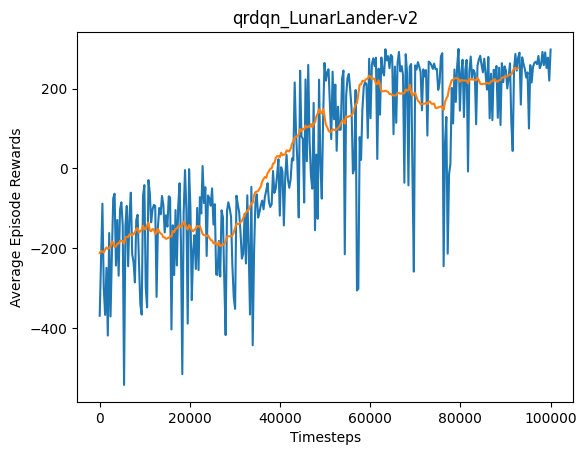

In [42]:
import pandas as pd
import os

# env_name = "CartPole-v1"
env_name = "LunarLander-v2"
# env_name = "Acrobot-v1"
# env_name = "ALE/Seaquest-v0"
# env_name = 'LunarLander-v2_1.5'


df_dir = os.path.join("logs", "qdqn", env_name,'monitor.csv')
# os.makedirs(log_dir, exist_ok=True)

df = pd.read_csv(df_dir, skiprows=1)
# env_name = "LunarLander-v2"

import numpy as np
from hyperparams import *
import matplotlib.pyplot as plt
# from hyperparams.qrdqn_hyper import 

timesteps = hyperdict_qrdqn[env_name]['n_timesteps']

y = df['r'].to_numpy()
x = np.linspace(1, timesteps, len(y))
plt.plot(x,y)

# plt.title('envn')
plt.xlabel('Timesteps')
plt.ylabel('Average Episode Rewards')




n = 25
mean_kernel = np.ones(n)/n
from scipy import signal

y_conv = np.convolve(y, mean_kernel, mode='valid')

plt.plot(x[:y_conv.shape[0]], y_conv)

plt.title("qrdqn_{}".format(env_name))
plt.xlabel('Timesteps')
plt.ylabel('Average Episode Rewards')

In [44]:
y_conv.shape

(310,)

In [46]:
print(x.shape)
print(y.shape)

(334,)
(334,)


In [8]:
import pandas as pd
import os
import numpy as np
from hyperparams import *
import matplotlib.pyplot as plt
from scipy import signal


env_list = ["CartPole-v1", "LunarLander-v2", "Acrobot-v1"]

y_list_qrdqn = []
y_list_categ = []

N_cutoff = 300

y_list=[]
for env_name in env_list:
    df_dir = os.path.join("logs", "qdqn", env_name,'monitor.csv')
    # os.makedirs(log_dir, exist_ok=True)

    df = pd.read_csv(df_dir, skiprows=1)
    # env_name = "LunarLander-v2"


    # from hyperparams.qrdqn_hyper import 
    timesteps = hyperdict_qrdqn[env_name]['n_timesteps']

    y = df['r'].to_numpy()
    x = np.linspace(1, timesteps, len(y))

    n = 25
    mean_kernel = np.ones(n)/n
    
    y_conv = np.convolve(y, mean_kernel, mode='valid')
    y_list.append(y_conv[:N_cutoff])

y_list_qrdqn = y_list

y_list=[]
for env_name in env_list:
    df_dir = os.path.join("logs", "categ", env_name,'monitor.csv')
    # os.makedirs(log_dir, exist_ok=True)

    df = pd.read_csv(df_dir, skiprows=1)

    # from hyperparams.qrdqn_hyper import 
    timesteps = hyperdict_categ[env_name]['n_timesteps']

    y = df['r'].to_numpy()
    x = np.linspace(1, timesteps, len(y))

    n = 25
    mean_kernel = np.ones(n)/n
    
    y_conv = np.convolve(y, mean_kernel, mode='valid')
    y_list.append(y_conv[:N_cutoff])

y_list_categ = y_list

In [32]:
len(y_list)

3

In [10]:
env_list


['CartPole-v1', 'LunarLander-v2', 'Acrobot-v1']

In [13]:
tmp = np.zeros(N_cutoff)
tmp[:y_list_categ[0].shape[0]] = y_list_categ[0]
tmp[y_list_categ[0].shape[0]:] = y_list_categ[0][y_list_categ[0].shape[0]-1]
y_list_categ[0] = tmp

In [14]:
print(y_list_categ[0].shape)
print(y_list_categ[1].shape)
print(y_list_categ[2].shape)

print(y_list_qrdqn[0].shape)
print(y_list_qrdqn[1].shape)
print(y_list_qrdqn[2].shape)

(300,)
(300,)
(300,)
(300,)
(300,)
(300,)


In [49]:
x.shape

(300,)

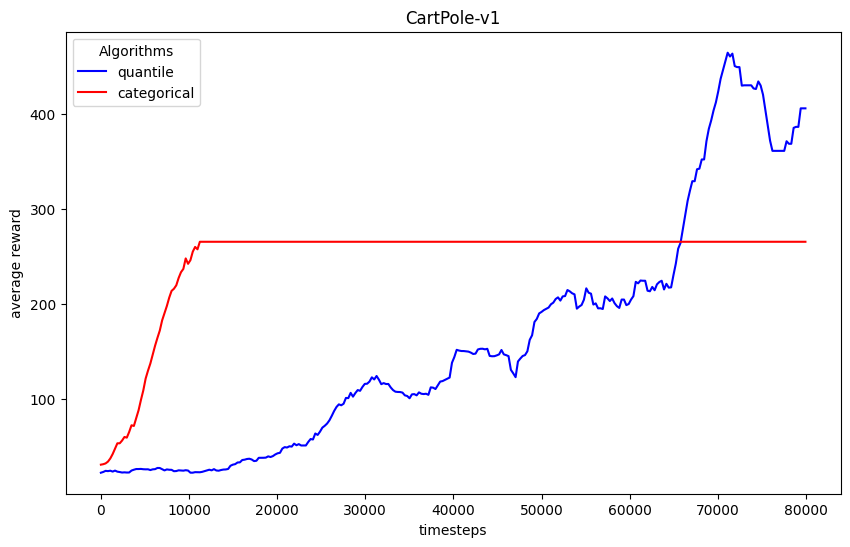

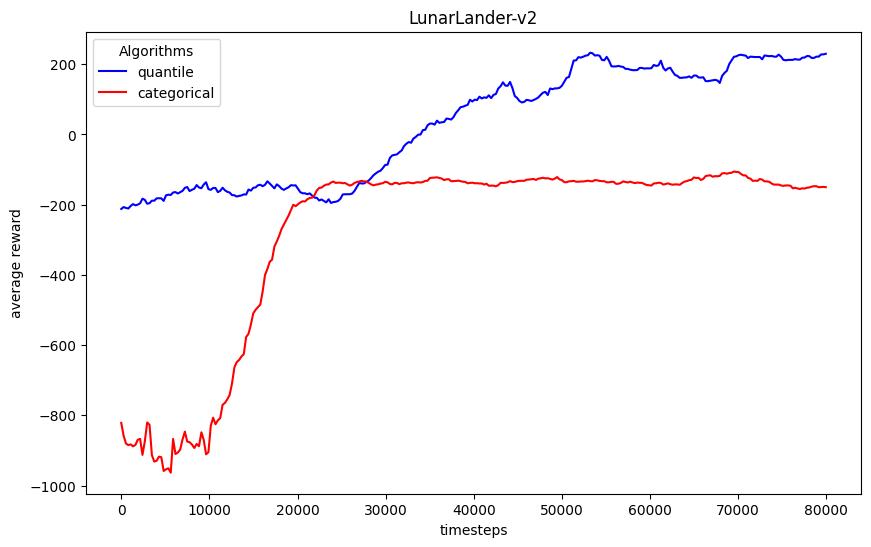

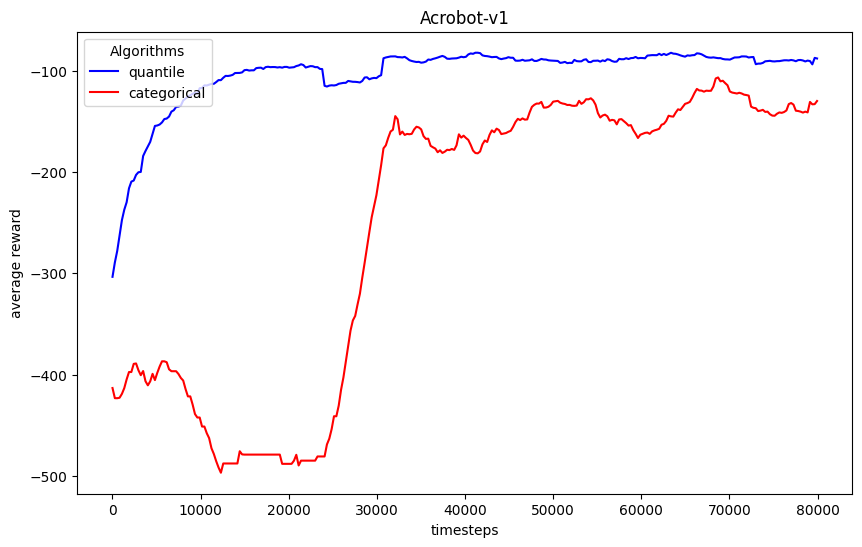

In [18]:
# Create a plot
x = x[:N_cutoff]

for i,env_name in enumerate(env_list):
    plt.figure(figsize=(10, 6))


    # Plot each curve with a different style, label, and color
    plt.plot(x, y_list_qrdqn[i], label='quantile', linestyle='-', color='blue')
    plt.plot(x, y_list_categ[i], label='categorical', linestyle='-', color='red')
    # plt.plot(x, y_list[2], label=env_list[2], linestyle='-', color='green')

    # Add a legend to the plot
    # Each entry in the legend automatically matches the color of its corresponding curve
    plt.legend(title='Algorithms', loc='upper left')

    # Add labels and title
    plt.xlabel('timesteps')
    plt.ylabel('average reward')
    plt.title(env_name)

    # Show the plot
    plt.show()

Text(0.45, 0, 'timesteps')

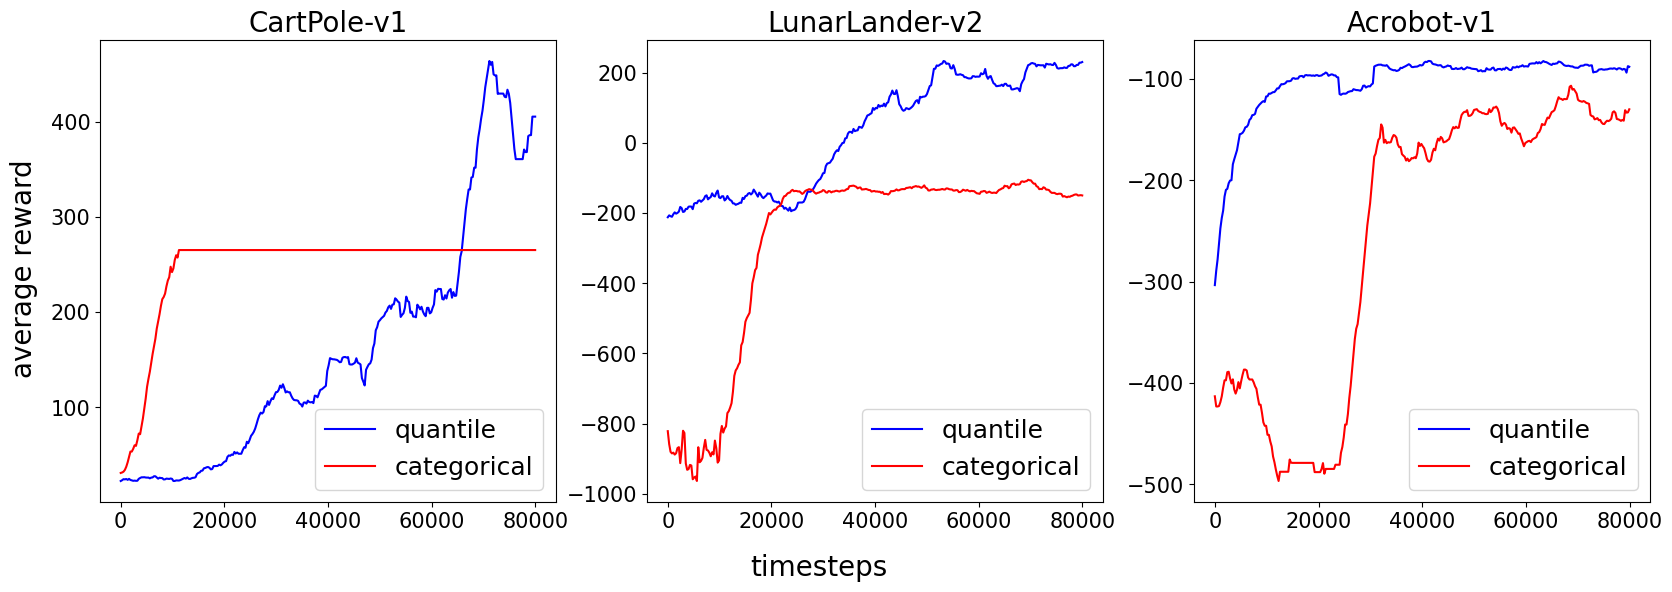

In [77]:
# Create a plot
x = x[:N_cutoff]

plt.rcParams['font.size'] = 12  # sets the default font size for all text elements
plt.rcParams['axes.titlesize'] = 20  # specific for subplot titles
plt.rcParams['axes.labelsize'] = 18  # specific for x and y labels
plt.rcParams['xtick.labelsize'] = 15  # specific for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 15  # specific for y-axis tick labels
plt.rcParams['legend.fontsize'] = 18  # specific for legend

fig, axs = plt.subplots(1, 3, figsize=(20, 6))


for i, env_name in enumerate(env_list):
    # plt.figure(figsize=(10, 6))


    # Plot each curve with a different style, label, and color
    axs[i].plot(x, y_list_qrdqn[i], label='quantile', linestyle='-', color='blue')
    axs[i].plot(x, y_list_categ[i], label='categorical', linestyle='-', color='red')
    # plt.plot(x, y_list[2], label=env_list[2], linestyle='-', color='green')

    # Add a legend to the plot
    # Each entry in the legend automatically matches the color of its corresponding curve
    axs[i].legend(loc='lower right')

    # Add labels and title
    # axs[i].set_xlabel('timesteps')
    # axs[i].set_ylabel('average reward')
    axs[i].set_title(env_name)

    # Show the plot
    # axs[i].show()
# fig.supylabel('average reward')
fig.text(0.08, 0.5, 'average reward', va='center', rotation='vertical', fontsize=20)
fig.text(0.45, 0, 'timesteps', va='center', rotation='horizontal', fontsize=20)
# fig.supxlabel('timesteps')
# plt.subplots_adjust(wspace=0.3, hspace=0)  # Adjust as needed


In [67]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b

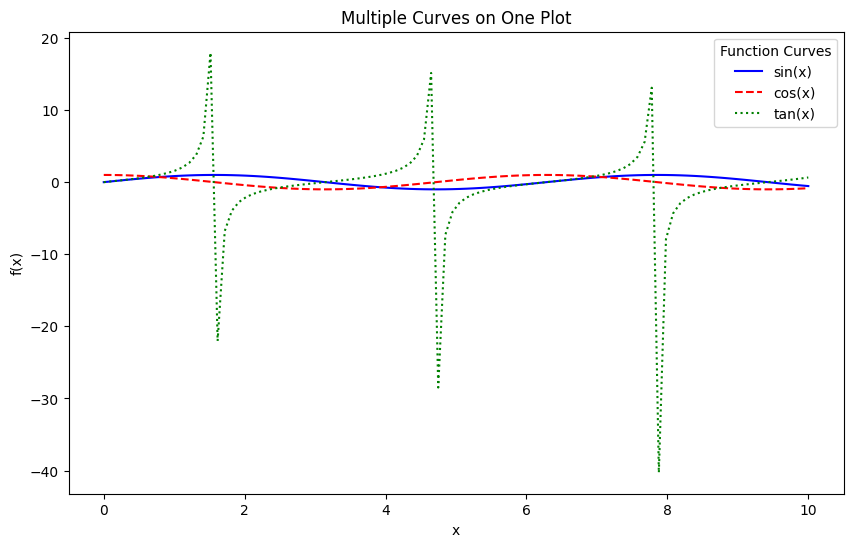

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a range of x values
x = np.linspace(0, 10, 100)

# Compute y values for each curve
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x)

# Create a plot
plt.figure(figsize=(10, 6))

# Plot each curve with a different style, label, and color
plt.plot(x, y1, label='sin(x)', linestyle='-', color='blue')
plt.plot(x, y2, label='cos(x)', linestyle='--', color='red')
plt.plot(x, y3, label='tan(x)', linestyle=':', color='green')

# Add a legend to the plot
# Each entry in the legend automatically matches the color of its corresponding curve
plt.legend(title='Function Curves')

# Add labels and title
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Multiple Curves on One Plot')

# Show the plot
plt.show()

Text(0, 0.5, 'Average Episode Rewards')

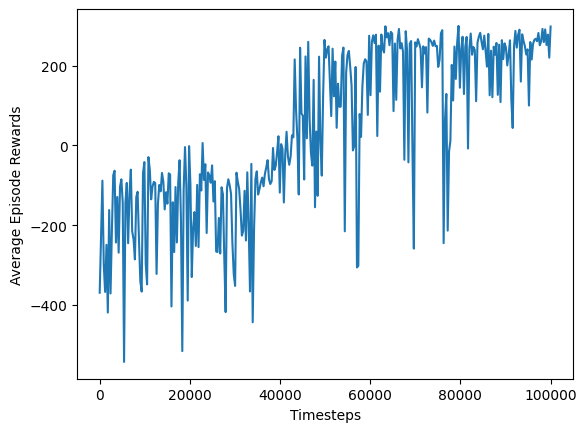

Text(0, 0.5, 'Average Episode Rewards')

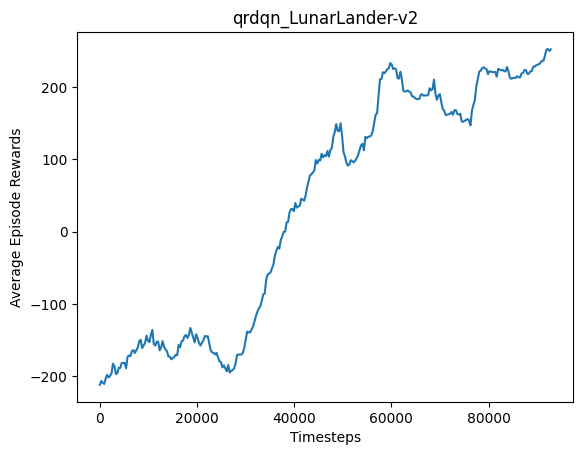

NameError: name 'hyperdict' is not defined

In [ ]:

z_projected = torch.zeros_like(probabilities)
z_projected.scatter_add_(1, l, lower)
z_projected.scatter_add_(1, u, upper)

Text(0, 0.5, 'Average Episode Rewards')

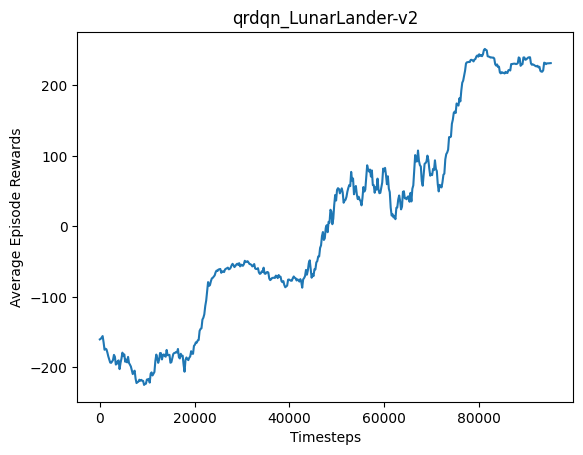

In [3]:
from collections import OrderedDict


In [10]:
hyperparams_cartpole = \
OrderedDict([('batch_size', 64),
             ('n_atoms', 51),
             ('n-hidden-units', 64),
             ('n_hidden_layers', 2),
             ('support_range', [0, 200]),
             ('start_train_at', 32),
             ('update_net_every', 5),
             ('epsilon', 0.1),
             ('n_steps', 20000),
             \
             ('buffer_size', 100000),
             ('exploration_final_eps', 0.04),
             ('exploration_fraction', 0.16),
             ('gamma', 0.99),
             ('gradient_steps', 128),
             ('learning_rate', 0.0023),
             ('learning_starts', 1000),
             ('n_timesteps', 50000.0),
             ('policy', 'MlpPolicy'),
             ('policy_kwargs', 'dict(net_arch=[256, 256], n_quantiles=10)'),
             ('target_update_interval', 10),
             ('train_freq', 256),
             ('normalize', False)
             ])

In [5]:
hyperparams_lunarlander = \
OrderedDict([('batch_size', 128),
             ('buffer_size', 100000),
             ('exploration_final_eps', 0.18),
             ('exploration_fraction', 0.24),
             ('gamma', 0.995),
             ('gradient_steps', -1),
             ('learning_rate', 'lin_1.5e-3'),
             ('learning_starts', 10000),
             ('n_timesteps', 100000.0),
             ('policy', 'MlpPolicy'),
             ('policy_kwargs', 'dict(net_arch=[256, 256], n_quantiles=170)'),
             ('target_update_interval', 1),
             ('train_freq', 256),
             ('normalize', False)])

In [119]:
y_conv

array([ 12.42,  12.53,  12.63,  13.01,  13.2 ,  13.34,  13.44,  13.69,
        14.  ,  14.15,  14.33,  14.58,  14.74,  14.88,  15.25,  15.94,
        16.06,  16.23,  16.44,  16.73,  17.03,  17.36,  17.79,  18.34,
        18.44,  18.54,  18.83,  19.05,  19.46,  19.78,  20.76,  21.15,
        21.54,  22.28,  22.47,  23.26,  23.6 ,  23.94,  24.15,  24.32,
        24.59,  24.79,  25.74,  25.95,  26.25,  26.59,  27.25,  27.51,
        28.3 ,  28.83,  29.24,  29.44,  30.63,  31.24,  31.29,  32.2 ,
        32.31,  32.99,  33.09,  33.24,  33.5 ,  33.67,  33.77,  34.71,
        35.5 ,  35.28,  36.93,  37.34,  38.24,  39.45,  40.16,  41.08,
        41.8 ,  43.58,  45.25,  46.54,  47.22,  47.88,  48.96,  50.43,
        51.52,  52.75,  52.72,  53.87,  54.93,  54.94,  56.17,  57.07,
        57.55,  58.69,  59.4 ,  60.49,  61.78,  61.79,  61.85,  62.83,
        63.71,  64.25,  65.07,  65.73,  66.61,  67.52,  68.49,  69.16,
        70.  ,  70.94,  71.93,  72.89,  73.91,  74.7 ,  75.53,  76.28,
      

In [120]:
y

array([ 21.,  14.,  19.,  17.,  39.,  20.,  49.,  22.,  33.,  17.,  18.,
        24.,  19.,  15.,  37.,  13.,  16.,  18.,  14.,  11.,  33.,  40.,
        19.,  14.,  17.,  41.,  43.,  12.,  28.,  16.,  46.,  21.,  12.,
        20.,  22.,  13.,  25.,  70.,  37.,  55.,  13.,  19.,  10.,  11.,
        12.,  13.,  59.,  24.,  45.,  16.,  11.,  10.,  38.,  19.,  14.,
        10.,  25.,  31.,  15.,  18.,  25.,  16.,  14.,  37.,  69.,  12.,
        17.,  21.,  29.,  30.,  33.,  43.,  55.,  10.,  10.,  29.,  22.,
        41.,  32.,  98.,  39.,  39.,  74.,  19.,  79.,  34.,  34.,  21.,
        17.,  27.,  20.,  95.,  21.,  30.,  34.,  66.,  26.,  79.,  53.,
        41.,  41., 133.,  80.,  22., 130.,  31., 117.,  32.,  48.,  43.,
        35.,  34., 113.,  94.,  15., 178.,  57., 108., 135.,  82., 125.,
       112., 197., 181., 146., 109., 109., 120., 175., 125., 169.,  18.,
       127., 126.,  23., 136., 115., 118., 151., 126., 122., 148.,  11.,
        17., 110., 101., 113., 106., 111., 104., 10

In [65]:
df.keys()

Index(['r', 'l', 't'], dtype='object')

In [83]:
timesteps

,index,r,l,t
0,0,-348.468209,108,0.532670
1,1,-112.443192,63,1.504754
2,2,-241.560948,64,2.775179
3,3,-295.752054,78,3.789603
4,4,-4.021307,91,5.241501
...,...,...,...,...
194,194,-11.944808,110,1396.068563
195,195,191.527933,941,1409.404710
196,196,229.365163,265,1413.288886
197,197,-72.270302,216,1416.185333


In [84]:
timesteps = 1e5

Text(0, 0.5, 'Average Episode Rewards')

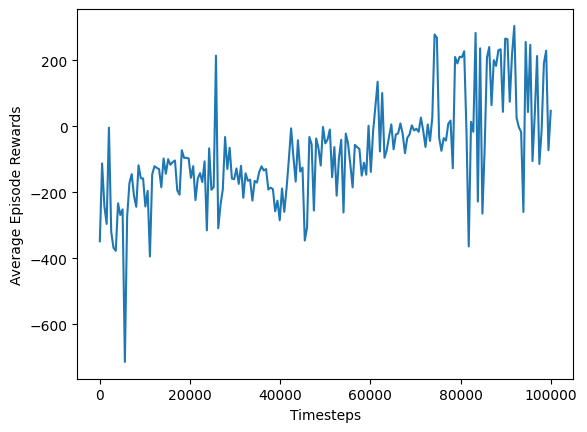

In [105]:
import numpy as np

y = df['r'].to_numpy()
x = np.linspace(1, timesteps, len(y))
plt.plot(x,y)

plt.title('Episode Rewards')
plt.xlabel('Timesteps')
plt.ylabel('Average Episode Rewards')

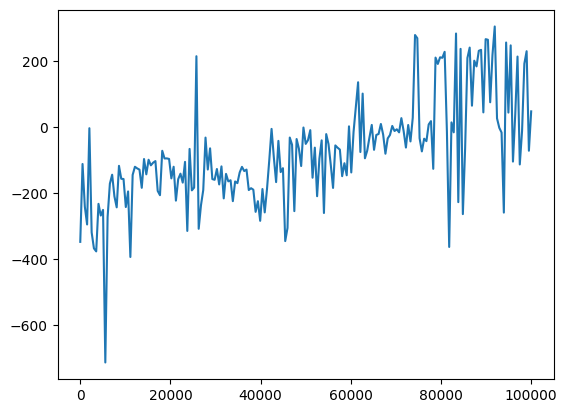

<Axes: >

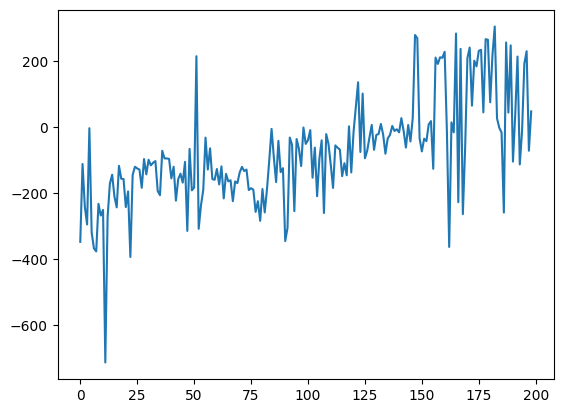

In [58]:
df['r'].plot()

<Axes: >

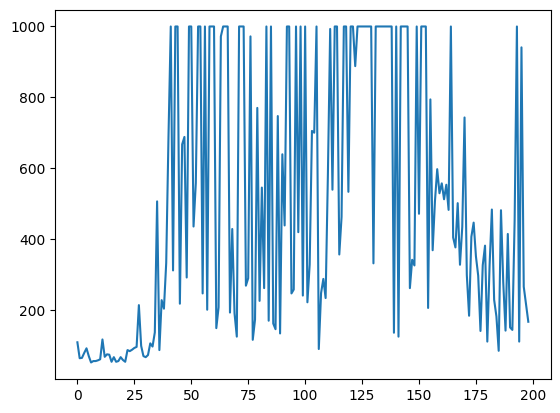

In [59]:
df['l'].plot()

<Axes: >

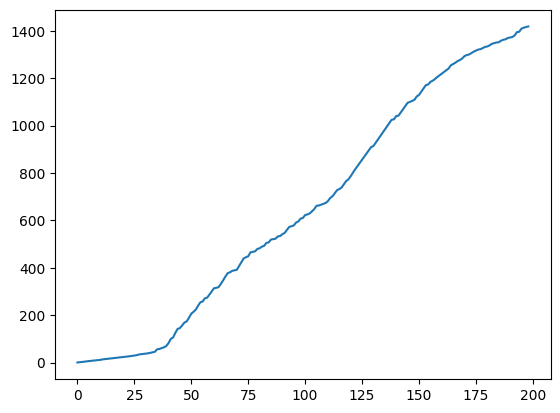

In [60]:
df['t'].plot()

In [36]:
env.action_space.n

4

In [5]:
import argparse
import copy
import random
import tqdm
import json
import numpy as np

import gym
import torch

import memory
from memory import Transition
import networks
from utils import np_to_unsq_tensor, squeeze_np
from experiment_utils import Plot

In [7]:
replay_buffer = memory.TransitionReplayBuffer(maxlen=32)

In [64]:
# env_name = 'Pendulum-v1'
env_name = 'CartPole-v0'
env = gym.make(env_name, render_mode="human")
state_dim = env.observation_space.shape[0]
env.reset()

/Users/alpayozkan/opt/anaconda3/envs/distrl_proj/lib/python3.11/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


(array([ 0.02632018, -0.03545529,  0.03741435, -0.03175322], dtype=float32),
 {})

In [66]:
action = torch.LongTensor([[env.action_space.sample()]])
next_state, reward, done, _, info= env.step(squeeze_np(action))
action
squeeze_np(action)

array(1)

In [11]:

next_state = np_to_unsq_tensor(next_state) if not done else None
replay_buffer.remember(
Transition(next_state, action, torch.tensor([[reward]]), next_state))
state = next_state    


/Users/alpayozkan/opt/anaconda3/envs/distrl_proj/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [16]:
replay_buffer.buffer

[Transition(state=tensor([[-0.0368, -0.2385, -0.0362,  0.2661]]), action=tensor([[0]]), reward=tensor([[1.]]), next_state=tensor([[-0.0368, -0.2385, -0.0362,  0.2661]]))]

In [51]:
torch.LongTensor([[env.action_space.sample()]]).shape

torch.Size([1, 1])

In [50]:
env.action_space.sample()

1

In [45]:
env.action_space.__dir__()

['n',
 'start',
 '_shape',
 'dtype',
 '_np_random',
 '__module__',
 '__doc__',
 '__init__',
 'is_np_flattenable',
 'sample',
 'contains',
 '__repr__',
 '__eq__',
 '__setstate__',
 '__orig_bases__',
 '__hash__',
 '__parameters__',
 'np_random',
 'shape',
 'seed',
 '__contains__',
 'to_jsonable',
 'from_jsonable',
 '__dict__',
 '__weakref__',
 '__slots__',
 '_is_protocol',
 '__class_getitem__',
 '__init_subclass__',
 '__annotations__',
 '__new__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__getstate__',
 '__subclasshook__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [46]:
env.action_space.n

2

In [57]:
torch.randn(4,1).int()

tensor([[0],
        [0],
        [1],
        [0]], dtype=torch.int32)

In [67]:
torch.randn(4,1).int()

tensor([[0],
        [0],
        [0],
        [0]], dtype=torch.int32)

In [71]:
squeeze_np(torch.randn(4,1).int()).reshape(4,1)

array([[ 3],
       [ 0],
       [-1],
       [ 0]], dtype=int32)

In [72]:

action = torch.randn(4,1).int()
next_state, reward, done, _, info= env.step(squeeze_np(torch.randn(4,1).int()).reshape(4,1))
next_state = np_to_unsq_tensor(next_state) if not done else None
replay_buffer.remember(
Transition(next_state, action, torch.tensor([[reward]]), next_state))
state = next_state    


AssertionError: array([[0],
       [0],
       [1],
       [1]], dtype=int32) (<class 'numpy.ndarray'>) invalid

: 

In [4]:
env.action_space.sample()

1

In [10]:
act_dim = env.action_space

In [11]:
env.action_space.shape

()

In [4]:
from collections import OrderedDict


In [5]:
n_timesteps = 50000.0
hyperparams = \
OrderedDict([('batch_size', 64),
             ('buffer_size', 100000),
             ('exploration_final_eps', 0.04),
             ('exploration_fraction', 0.16),
             ('gamma', 0.99),
             ('gradient_steps', 128),
             ('learning_rate', 0.0023),
             ('learning_starts', 1000),
            #  ('n_timesteps', 50000.0),
             ('policy', 'MlpPolicy'),
             ('policy_kwargs', 'dict(net_arch=[256, 256], n_quantiles=10)'),
             ('target_update_interval', 10),
             ('train_freq', 256),
            #  ('normalize', False)
             ])

In [6]:
hyperparams['n_timesteps']

KeyError: 'n_timesteps'

In [10]:
n_timesteps = 50000.0
hyperparams = \
OrderedDict([('batch_size', 64),
             ('buffer_size', 100000),
             ('exploration_final_eps', 0.04),
             ('exploration_fraction', 0.16),
             ('gamma', 0.99),
             ('gradient_steps', 128),
             ('learning_rate', 0.0023),
             ('learning_starts', 1000),
             ('n_timesteps', 50000.0),
             ('policy', 'MlpPolicy'),
             ('policy_kwargs', 'dict(net_arch=[256, 256], n_quantiles=10)'),
             ('target_update_interval', 10),
             ('train_freq', 256),
             ('normalize', False)
             ])

In [11]:
hyperparams

OrderedDict([('batch_size', 64),
             ('buffer_size', 100000),
             ('exploration_final_eps', 0.04),
             ('exploration_fraction', 0.16),
             ('gamma', 0.99),
             ('gradient_steps', 128),
             ('learning_rate', 0.0023),
             ('learning_starts', 1000),
             ('n_timesteps', 50000.0),
             ('policy', 'MlpPolicy'),
             ('policy_kwargs', 'dict(net_arch=[256, 256], n_quantiles=10)'),
             ('target_update_interval', 10),
             ('train_freq', 256),
             ('normalize', False)])

In [3]:
import gymnasium as gym

from sb3_contrib import QRDQN

env = gym.make("CartPole-v1", render_mode="human")

policy_kwargs = dict(n_quantiles=50)
model = QRDQN(
              hyperparams['policy'], 
              env,
              batch_size=hyperparams['batch_size'],
              buffer_size=hyperparams['buffer_size'],
              exploration_final_eps=hyperparams['exploration_final_eps'],
              exploration_fraction=hyperparams['exploration_fraction'],
              gamma=hyperparams['gamma'],
              gradient_steps=hyperparams['gradient_steps'],
              learning_rate=hyperparams['learning_rate'],
              learning_starts=hyperparams['learning_starts'],
              
              policy_kwargs=eval(hyperparams['policy_kwargs']),
              target_update_interval=hyperparams['target_update_interval'],
              train_freq=hyperparams['train_freq'],
              verbose=1
              )




NameError: name 'hyperparams' is not defined

In [16]:
env.spec.id

'CartPole-v1'

In [17]:
import stable_baselines3

In [18]:
stable_baselines3.common.atari_wrappers.AtariWrapper()

TypeError: AtariWrapper.__init__() missing 1 required positional argument: 'env'

In [28]:
from collections import OrderedDict

import gymnasium
from gymnasium.wrappers import FrameStack

import stable_baselines3

from sb3_contrib import QRDQN

In [33]:
hyperparams_seaquest = \
OrderedDict([('env_wrapper',
              ['stable_baselines3.common.atari_wrappers.AtariWrapper']),
             ('exploration_fraction', 0.025),
             ('frame_stack', 4),
             ('n_timesteps', 10000000.0),
             ('optimize_memory_usage', True),
             ('policy', 'CnnPolicy'),
             ('normalize', False)])

hyperparams = hyperparams_seaquest

env = gymnasium.make("ALE/Seaquest-v5",render_mode="human")
env_wrap = FrameStack(env, num_stack=hyperparams['frame_stack'])
wrapped_env = stable_baselines3.common.atari_wrappers.AtariWrapper(env)


In [34]:

model = QRDQN(
            hyperparams['policy'], 
            env=env,
            exploration_fraction=hyperparams['exploration_fraction'],
            # optimize_memory_usage=hyperparams['optimize_memory_usage'],
            verbose=1
            )

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/Users/alpayozkan/opt/anaconda3/envs/distrl_proj/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 201.62GB > 6.00GB
  warnings.warn(


In [35]:
model.learn(total_timesteps=hyperparams['n_timesteps'], 
            log_interval=4)
model.save("qrdqn_" + env_name)

del model # remove to demonstrate saving and loading



: 

In [ ]:
model = QRDQN.load("qrdqn_" + env_name)

obs, _ = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
      obs, _ = env.reset()

In [42]:
eval(hyperparams['policy_kwargs'])

{'net_arch': [256, 256], 'n_quantiles': 10}

In [26]:
hyperparams

OrderedDict([('batch_size', 64),
             ('buffer_size', 100000),
             ('exploration_final_eps', 0.04),
             ('exploration_fraction', 0.16),
             ('gamma', 0.99),
             ('gradient_steps', 128),
             ('learning_rate', 0.0023),
             ('learning_starts', 1000),
             ('policy', 'MlpPolicy'),
             ('policy_kwargs', 'dict(net_arch=[256, 256], n_quantiles=10)'),
             ('target_update_interval', 10),
             ('train_freq', 256)])

In [18]:
import gymnasium as gym

from sb3_contrib import QRDQN

env = gym.make("CartPole-v1", render_mode="human")

policy_kwargs = dict(n_quantiles=50)
model = QRDQN(
   env,
   batch_size=64,
   buffer_size=100000,
   exploration_final_eps=0.04,
   exploration_fraction=0.16,
   gamma=0.99,
   gradient_steps=128,
   learning_rate=0.0023,
   learning_starts=1000,
   policy='MlpPolicy',
   verbose=1)

model.learn(total_timesteps=10_000, log_interval=4)
model.save("qrdqn_cartpole")

del model # remove to demonstrate saving and loading

model = QRDQN.load("qrdqn_cartpole")

obs, _ = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
      obs, _ = env.reset()

TypeError: QRDQN.__init__() got multiple values for argument 'policy'

In [ ]:
model.learn(total_timesteps=10_000, log_interval=4)
model.save("qrdqn_cartpole")

del model # remove to demonstrate saving and loading

model = QRDQN.load("qrdqn_cartpole")

obs, _ = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
      obs, _ = env.reset()